In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import *
import jetson_configs as cfg

from src.ml_helpers.compile_ml_results import *

In [2]:
split_date = cfg.train_test_split
horizon = 1
admin_level = 'admin1'
fpath = f"{admin_level}_lag{horizon}"

In [3]:
compile_ml_results(fpath)

# Import results

In [4]:
bl  = pd.read_csv(f"ml/output_data/{fpath}/results_baseline.csv",    index_col=[ 'region','date'], parse_dates=['date'])
ml  = pd.read_csv(f"ml/output_data/{fpath}/results_ml_compiled.csv", index_col=['region', 'date'], parse_dates=['date'])

#eur = pd.read_csv("results/eureqa_compiled.csv",  index_col=[ 'region','date'], parse_dates=['date'])
#h2o = pd.read_csv("results/h2o_compiled.csv",     index_col=[ 'region','date'], parse_dates=['date'])
#rnn = pd.read_csv("results/rnn_compiled.csv",     index_col=[ 'region','date'], parse_dates=['date'])

## Label train/test

In [5]:
# Add an indicator for the dataset used 
ml['dataset'] = np.where(ml.index.get_level_values("date") <= pd.to_datetime(split_date), 'train', 'test')

In [6]:
#.apply(lambda x: x+ relativedelta(months=horizon))

## Merge them

In [7]:
compiled_df = bl.merge(ml, left_index=True, right_index=True, how='outer')
#compiled_df = compiled_df.merge(eur, left_index=True, right_index=True, how='outer')
#compiled_df = compiled_df.merge(h2o, left_index=True, right_index=True, how='outer')
#compiled_df = compiled_df.merge(rnn, left_index=True, right_index=True, how='outer')

## Heuristically remove outliers

In [8]:
for v in compiled_df.columns:
    if 'dataset' not in v and v!='features_date':
        
        # No negative arrivals
        compiled_df[v] = np.where(compiled_df[v]<0, 0, compiled_df[v])
        
        # No arrivals in excess of half a million
        compiled_df[v] = np.where(compiled_df[v]>500000, 500000, compiled_df[v])

### Tidy column names

In [9]:
compiled_df.columns = [i.replace("predicted_","")   for i in compiled_df.columns]

In [10]:
# Round all predictions to whole numbers
compiled_df = compiled_df.round(0)

### Export

In [11]:
compiled_df[[i for i in compiled_df.columns if 'model_' not in i]].to_csv(f"ml/output_data/master_{fpath}.csv")

In [12]:
# Note: some of the earlier models have missing values; a comparison between models using all observations is therefore not totally valid
#compiled_df[compiled_df.true.isna()==False].count()

In [13]:
mean_arrivals = compiled_df.true.groupby(['region']).mean().astype(int)
regions = compiled_df.index.get_level_values("region").unique()

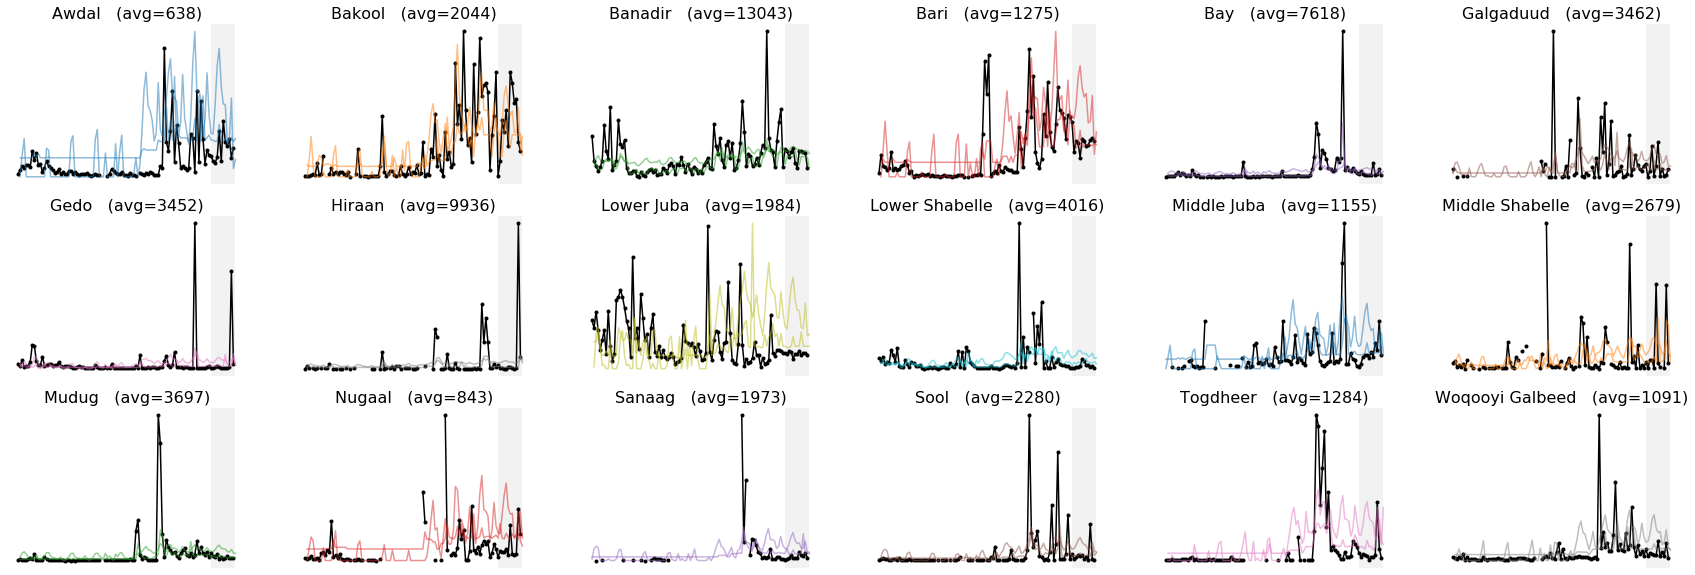

In [14]:
fig, ax = plt.subplots(3,6, figsize=[30,10])

plot_df = compiled_df['true'].unstack(level='region')
plot_df.plot(subplots=True, ax=ax, #logy=True, 
             color='black', 
             marker=".", 
             legend=None)

for c in ['Perceptron', 'Xgboost']:
    plot_df = compiled_df[c].unstack(level='region')
    plot_df.plot(subplots=True, ax=ax, #logy=True, 
                 legend=None, alpha=0.5)

for a in range(0,18):
    i = a//6
    j = a%6
    ax[i][j].axis("Off")
    r = plot_df.columns[a] 
    ax[i][j].set_title(f"{r}   (avg={mean_arrivals.loc[r]})", fontsize=16)
    ax[i][j].axvspan("2018-12-01", "2019-12-01", facecolor='darkgrey', alpha=0.15)
    
plt.savefig("figures/trends.png", dpi=100, bbox_inches="tight")
plt.show()

In [15]:
compiled_df.shape

(1944, 121)